In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [3]:
def get_persistent_jet_spells(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None):
    props_as_df = extract_season_from_df(props_as_df, season)
    times = props_as_df["time"].unique()
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric]
    if metric == "com_speed":
        out = (out < out.quantile(0.2))
    else:
        out = (out > out.quantile(0.8))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= 4).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.with_columns(time=times[out["range"]])
    out = out.join(props_as_df, on="time").drop("value", "start", "range")
    return out

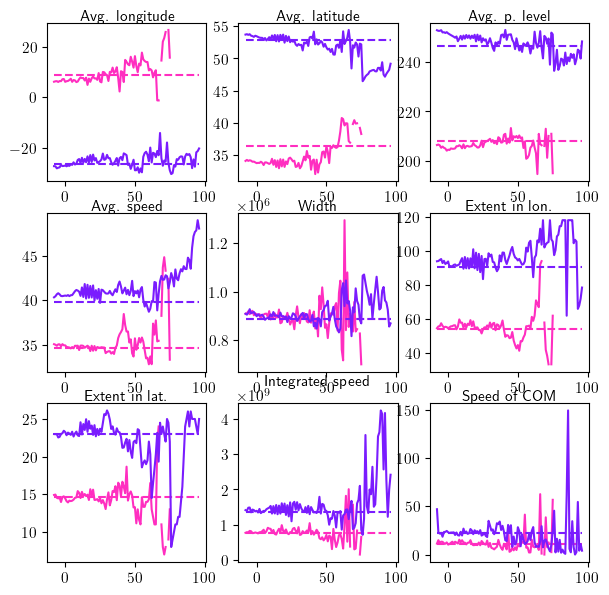

In [4]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

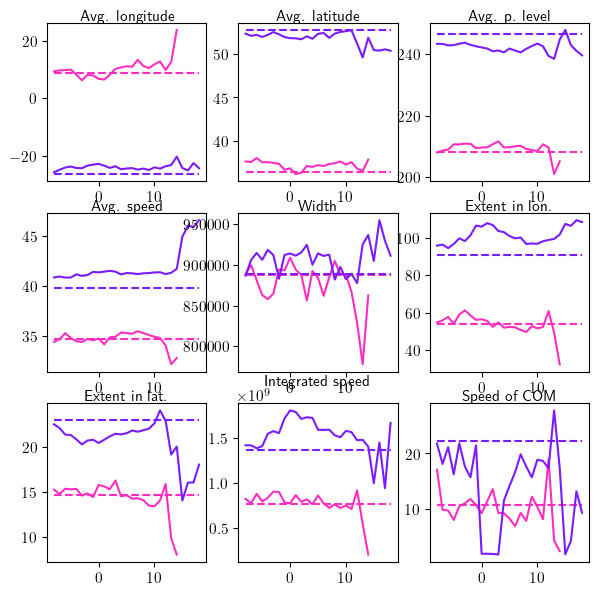

In [5]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

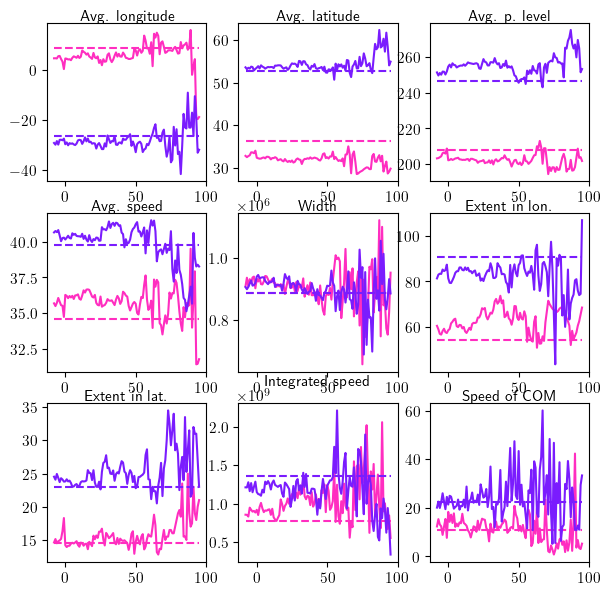

In [6]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

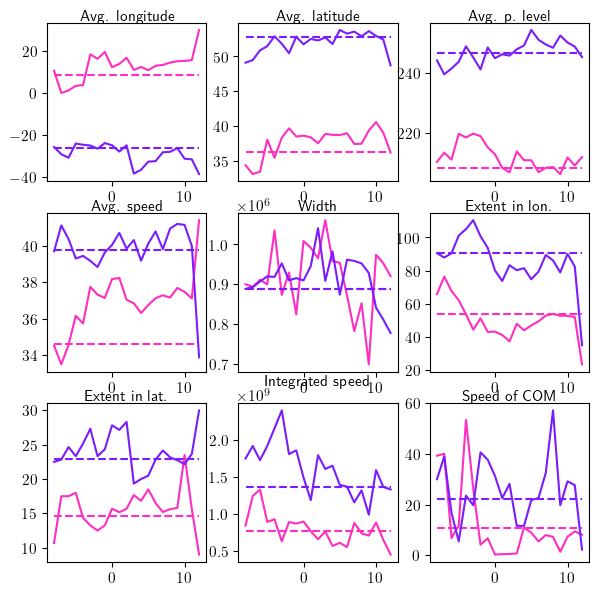

In [7]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [9]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [10]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed", "persistence", "waviness1", "wavinessR16"]
times = props_as_df["time"].unique()
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
labels_time = labels_df["time"].unique(maintain_order=True)
persistent_spells = labels_df["labels"].rle().struct.unnest()
persistent_spells = persistent_spells.filter(pl.col("len") >= 8)
persistent_spells = persistent_spells.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
nt_before, nt_after = 8, 0
persistent_spells = persistent_spells.filter(pl.col("len") >= 4).with_columns(
    range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
    relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
)
persistent_spells = persistent_spells.with_row_index("persistent_spell").explode(["range", "relative_index"])
persistent_spells = persistent_spells.with_columns(time=times[persistent_spells["range"]])
persistent_spells = persistent_spells.join(props_as_df, on="time").drop("start", "range")

In [16]:
mean_ps = persistent_spells.group_by(["value", "relative_index", "jet"]).agg(**aggs).sort(["value", "relative_index", "jet"])
props_on_som = labels_df.join(props_as_df.cast({"time": labels_df["time"].dtype}), on="time")
props_on_som = props_on_som.drop("time").group_by(["labels", "jet"], maintain_order=True).mean().sort(["labels", "jet"])

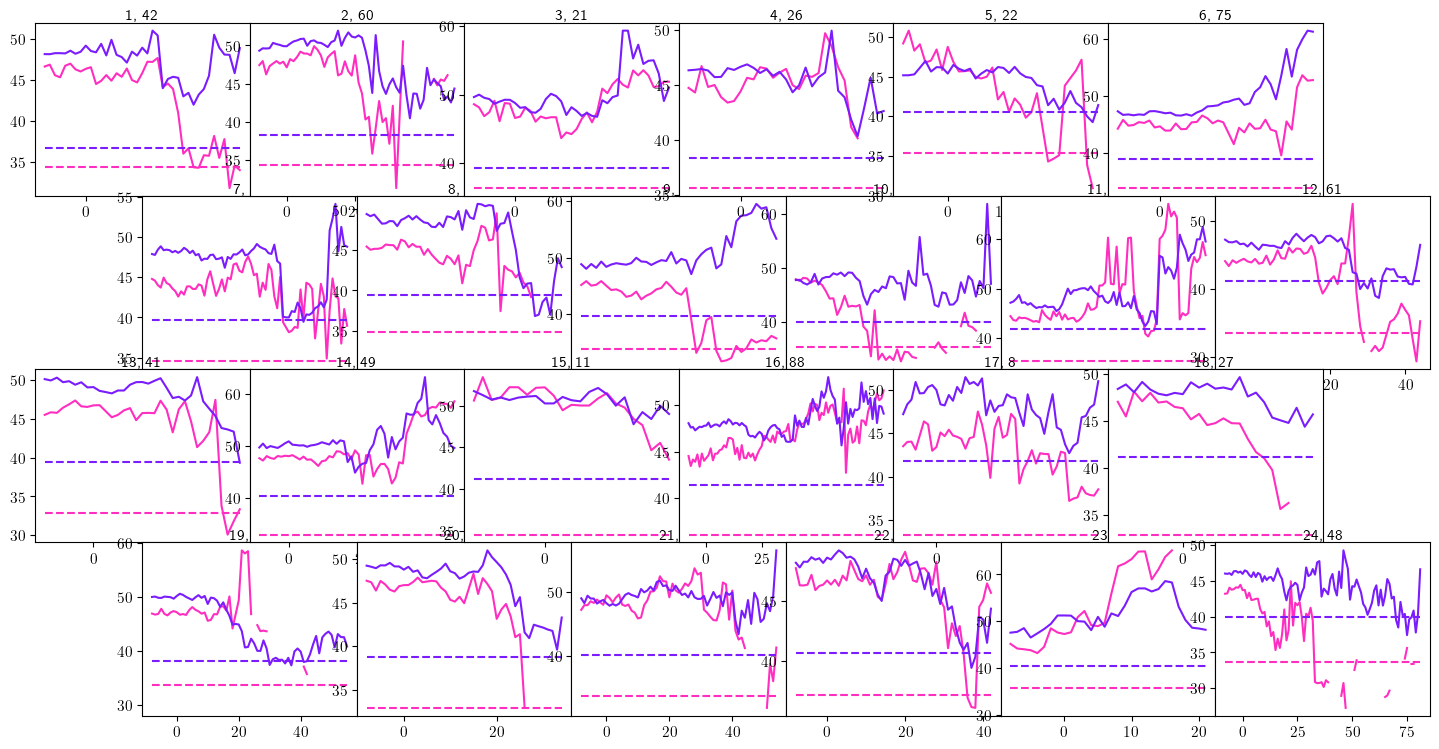

In [17]:
x = mean_ps["relative_index"].unique()
data_var = "mean_s"
many_colors = colormaps.cet_g_bw(np.linspace(0, 1, 256))
fig, axes = honeycomb_panel(4, 6, ratio = 0.5)
axes = axes.ravel()
for value in range(24):
    ax = axes[value]
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("value") == value, pl.col("jet") == jet)
        x_ = x[:len(to_plot)]
        ax.plot(x_, to_plot[data_var], color=COLORS[2 - j])
        this_mean = props_on_som.filter(pl.col("labels") == value, pl.col("jet") == jet)
        if len(x_) == 0:
            continue
        ax.plot([x_[0], x_[-1]], [this_mean[data_var], this_mean[data_var]], ls="dashed", color=COLORS[2 - j])
    title = value + 1
    try:
        title = f"{title}, {to_plot['alive'][0]}"
    except IndexError:
        pass
    ax.set_title(title)

In [18]:
mean_ps = persistent_spells.group_by(["relative_index", "jet"]).agg(**aggs).sort(["relative_index", "jet"])

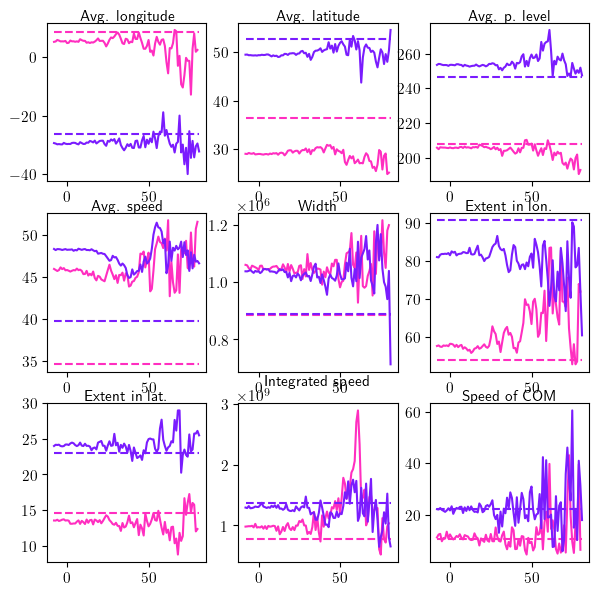

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])